In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy

In [2]:
image_path = cv2.imread('sar_3.jpg')
image = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [3]:
image_hough = image.copy()

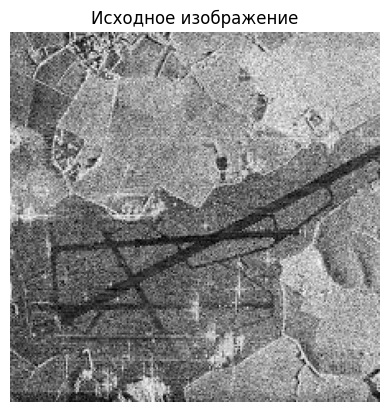

In [4]:
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

In [5]:
# Детектор Канни
canny = cv2.Canny(image_gray, 50, 150, apertureSize=3)

In [6]:
# Преобразование Хафа
lines = cv2.HoughLines(canny, 1, np.pi / 180, 140)

In [7]:
longest_line_info = None
max_length = 0

In [8]:
if lines is not None:
    
    all_lines = []

    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]

        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho

        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        length = np.sqrt((pt2[0] - pt1[0]) ** 2 + (pt2[1] - pt1[1]) ** 2)

        if length > max_length:
            max_length = length
            longest_line_info = (rho, theta, pt1, pt2)
    
    if longest_line_info is not None:
        rho, theta, pt1, pt2 = longest_line_info
        cv2.line(image_hough, pt1, pt2, (255, 0, 0), 4, cv2.LINE_AA)

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

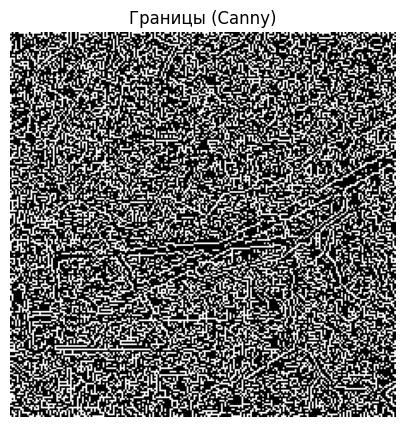

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(canny, cmap='gray')
plt.title('Границы (Canny)')
plt.axis('off')

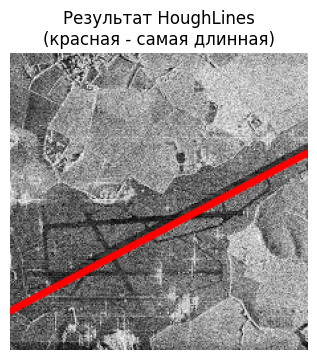

In [10]:
plt.subplot(1, 2, 2)
plt.imshow(image_hough)
plt.title('Результат HoughLines\n(красная - самая длинная)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
bin_img = copy.deepcopy(image_gray)
T  = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

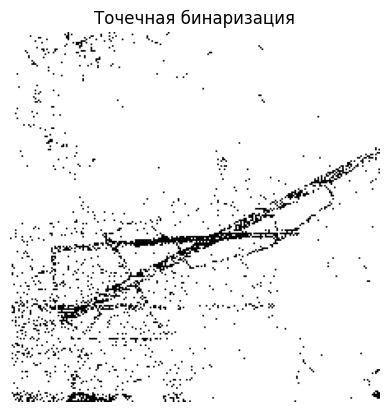

In [12]:
plt.imshow(bin_img, cmap='gray')
plt.title('Точечная бинаризация')
plt.axis('off')
plt.show()

In [13]:
_,th2 = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

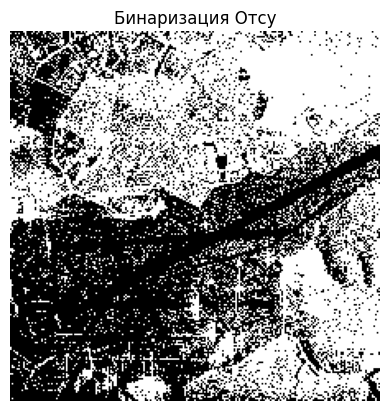

In [14]:
plt.imshow(th2, cmap='gray')
plt.title('Бинаризация Отсу')
plt.axis('off')
plt.show()

In [15]:
th3 = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,71,21)

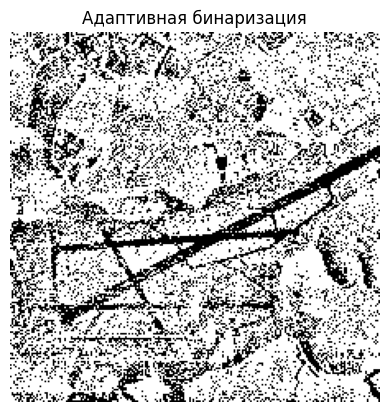

In [16]:
plt.imshow(th3, cmap='gray')
plt.title('Адаптивная бинаризация')
plt.axis('off')
plt.show()

In [17]:
scale = 1
delta = 0
ddepth = cv2.CV_16S
grad_x = cv2.Sobel(image_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(image_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad = cv2.addWeighted(grad_x, 0.5, grad_y, 0.5,0.0)

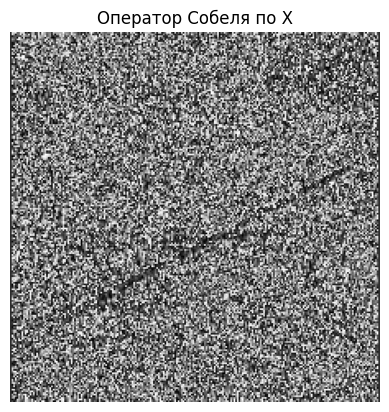

In [18]:
plt.imshow((grad_x - grad_x.min())*255, cmap='gray')
plt.title('Оператор Собеля по Х')
plt.axis('off')
plt.show()

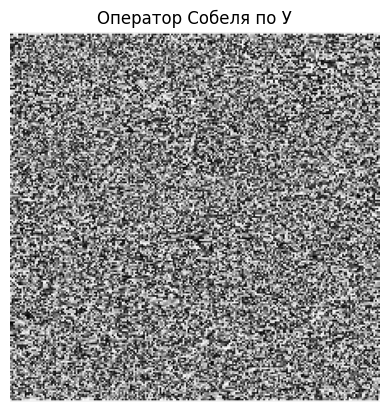

In [19]:
plt.imshow((grad_y - grad_y.min())*255, cmap='gray')
plt.title('Оператор Собеля по У')
plt.axis('off')
plt.show()

In [20]:
th3 = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,71,21)

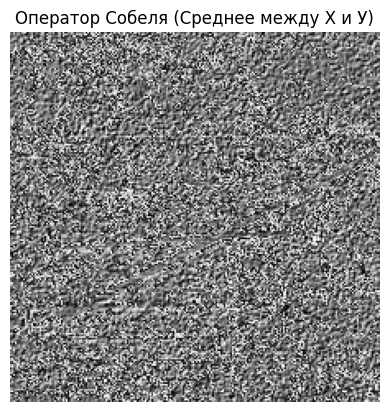

In [21]:
plt.imshow((grad - grad.min())*255, cmap='gray')
plt.title('Оператор Собеля (Среднее между Х и У)')
plt.axis('off')
plt.show()

In [22]:
blur = cv2.GaussianBlur(bin_img, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 55, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_line_road = image.copy()

In [23]:
road_mask = np.zeros_like(image_gray)
image_with_roads = image.copy()

In [24]:
if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            cv2.fillPoly(road_mask, [contour], 255)
            cv2.fillPoly(image_with_roads, [contour], (0, 0, 255))

In [25]:
road = cv2.bitwise_and(image, image,mask=road_mask)

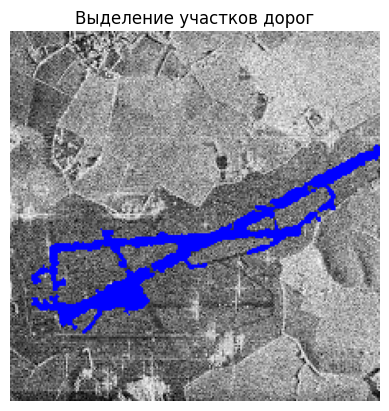

In [26]:
plt.imshow(image_with_roads, cmap='gray')
plt.title('Выделение участков дорог')
plt.axis('off')
plt.show()